# Project 2: Customer Churn

## Index
1. [Introduction](#1)
2. [Exploratory Data Analysis](#2)
    * [Monthly charges](#21)
    * [Total Charges](#22)
3. [Data Transformation](#3)
4. [Models](#4)
    

<a id  = "1"></a>
## Introduction <a id  = "Introduction"></a>


what is the project about. 
business proccess goes in here.
wdddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd,M<br>
wdwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww<br>faaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa<br>

In [102]:
import pandas as pd
import numpy as np
from category_encoders import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline # Model pipeline
from sklearn.metrics import accuracy_score #Metrices
from sklearn.model_selection import train_test_split
import plotly.express as px 
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import seaborn as sns
# Supress warnings
import warnings
warnings.simplefilter(action="ignore", category=Warning)

In [103]:
data_df = pd.read_csv("src/data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(data_df.isna().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


<a id  = "2"></a>
## Exploratory Data Analysis


<a id  = "21"></a>
### Monthly Charges
The 'MonthlyCharges' column represents the amount of money each customer pays for a subscription to one or more of the services  the company provides.


In [104]:
missing_values = data_df['MonthlyCharges'].isnull().sum()
print(f"missing values: {missing_values}")
only_numbers = data_df['MonthlyCharges'].dtype == 'float64'
print(f"Only numeric values: {only_numbers}")
print(f"Total number of values: {len(data_df['MonthlyCharges'])}")


missing values: 0
Only numeric values: True
Total number of values: 7043


There are no missing values and only numeric values in the column. 

Box plot: Identifying outliers

In [105]:
#Outliers Identification
Q1 = data_df['MonthlyCharges'].quantile(0.25)
Q3 = data_df['MonthlyCharges'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#isolate outliers
outliers_indexes = []
counter = 0
for index, row in enumerate(data_df['MonthlyCharges']):
    if row < lower_bound:
        outliers_indexes.append(index)
    else:
        if row > upper_bound:
            outliers_indexes.append(index)
Outliers_df = data_df['MonthlyCharges'].loc[outliers_indexes] 

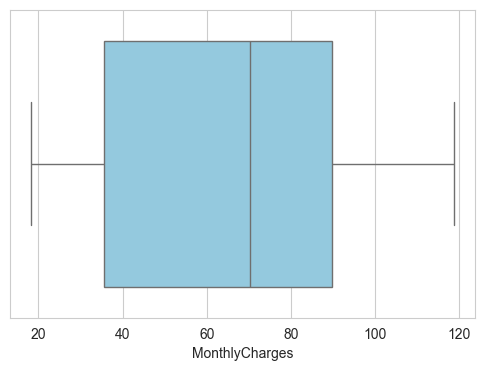

Number of outliers: 0


In [106]:
#Plot the box plot of the Monthly charges column
plt.figure(figsize=(6,4))
sns.boxplot(x=data_df['MonthlyCharges'], color='skyblue')
sns.swarmplot(x=Outliers_df, color='red', label='Outliers')
plt.show() 
print(f"Number of outliers: {len(Outliers_df)}")

In [107]:
#function to plot histogram
def plt_hist(data):
    plt.figure(figsize=(5, 5))
    sns.histplot(data, kde=True, bins=20)
    plt.title(f'Distribution of the {data.name}')
    plt.xlabel(f'{data.name}')
    plt.xticks(rotation=5)
    plt.show()
    return

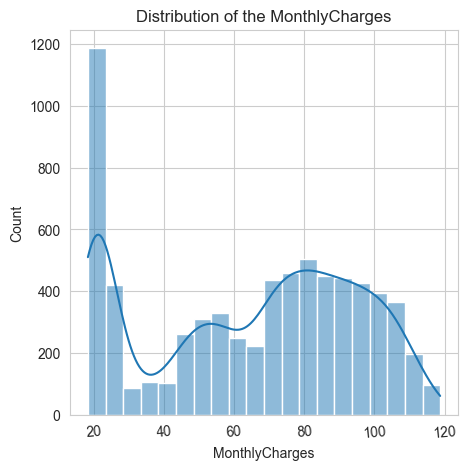

Skewness coefficient: -0.22	Kurtosis coefficent: -1.26


In [108]:
#skewness
skew_coef =data_df['MonthlyCharges'].skew().__round__(2)
kurt_coeff = data_df['MonthlyCharges'].kurt().__round__(2)
plt_hist(data_df['MonthlyCharges'])
print(f"Skewness coefficient: {skew_coef}\tKurtosis coefficent: {kurt_coeff}")


The kurtosis coefficient (k < 0): Tells us that the data is unbalanced. It has a heavier tail to the right. From the diagram we see a spike at around $20, this odd spike is what may be causing the skewness value. This spike will be removed.   

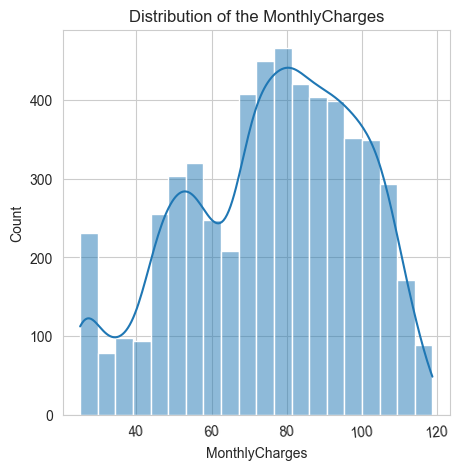

In [109]:
#drop rows where monthly charges are less than 25
data_df = data_df[data_df['MonthlyCharges'] > 25]
plt_hist(data_df['MonthlyCharges'])

The monthly charges column is multimodal distributed. This means the data might be segmented into different groups such as, lower, middle and higher monthly charges based on their subscription choices. 

Monthly Charges and Churn <br>
The relationship between the monthly charges and churn will be evaluated.  

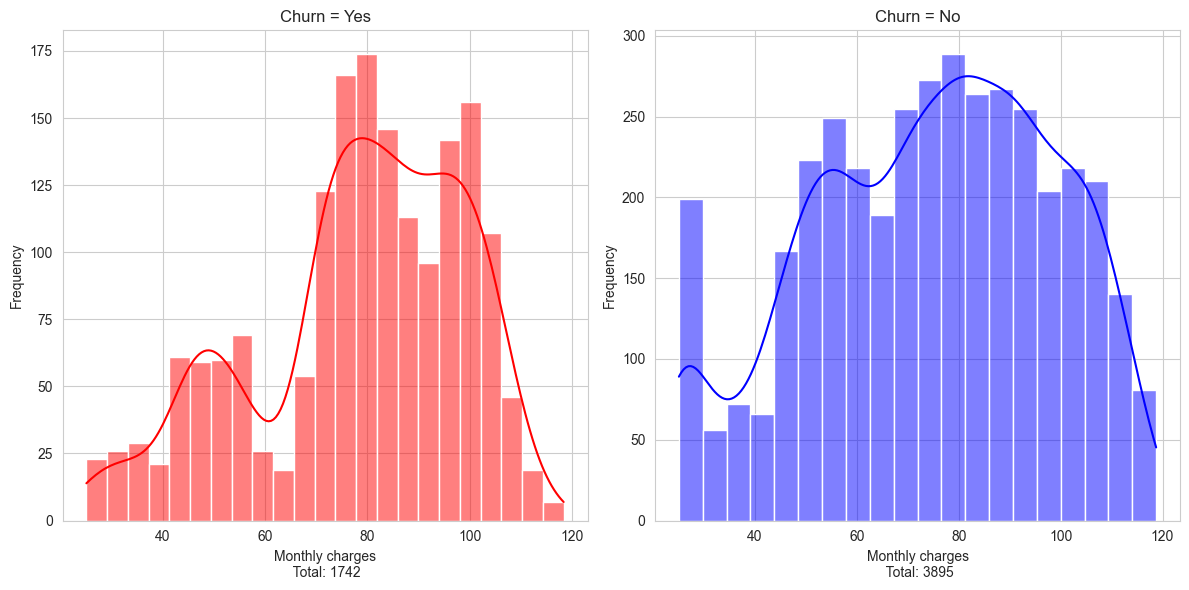

Percentage of customers who leave: 30.9%


In [110]:
yes = data_df[data_df['Churn'] == 'Yes']
no = data_df[data_df['Churn'] == 'No']
# Set the style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Churn = Yes
sns.histplot(data=data_df[data_df['Churn'] == 'Yes'], x='MonthlyCharges', ax=axes[0], kde=True, color='red')
axes[0].set_title('Churn = Yes')
axes[0].set_xlabel(f'Monthly charges\n Total: {len(yes)}')
axes[0].set_ylabel('Frequency')


# Plot for MonthlyCharges Vs. Churn = no
sns.histplot(data=data_df[data_df['Churn'] == 'No'], x='MonthlyCharges', ax=axes[1], kde=True, color='blue')
axes[1].set_title('Churn = No')
axes[1].set_xlabel(f'Monthly charges\n Total: {len(no)}')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()
print(f"Percentage of customers who leave: {(len(yes)*100/ len(data_df)).__round__(2)}%")


Customers who pay montthly charges between $60 and $80 have the highest rate of churn, these are customers who are likely to leave. The lowest churn rate is between $80 and $90, this means even though customers are churning they are more likely to stay than to churn. There is a higher number of customers who do not churn in the lower monthly payment region than those who do. however, the churn **rate** and non-churn rate appears to be almost equal for values above $100. 

<a id  = "22"></a>
### Total Charges
The total charges column represent the total amount charged to the customer throughout their subscription period (tenure). It can be compromised from one or more service subscriptions. 

In [111]:
missing_values = data_df['TotalCharges'].isnull().sum()
print(f"missing values: {missing_values}")
only_numbers = data_df['TotalCharges'].dtype == 'float64'
print(f"Only numeric values: {only_numbers}")
print(f"Total number of values: {len(data_df['TotalCharges'])}")


missing values: 0
Only numeric values: False
Total number of values: 5637


The total charges column appears to have non-numeric vaues. these values must be:
- checked to see if they are numbers stored as strings, 
- if they are numbers stored as strings conversion will take place, else, these values will be repllaced by NAN using pandas,then replaced with the mean of the column.

In [112]:
#replace any empty strings with NAN
data_df['TotalCharges'] = data_df['TotalCharges'].replace(" ", np.nan)

#convert object to numberic if there are letters the following
#code will throw an error
data_df['TotalCharges'] = pd.to_numeric(data_df['TotalCharges'])
print(f"New datatype: {data_df['TotalCharges'].dtype}")
print(f"Missing values: {data_df['TotalCharges'].isna().sum()}")

New datatype: float64
Missing values: 7


There are 7 missing values and these missing values will be replaced with the mean of the column.

In [113]:
#fill missing values with mean
data_df['TotalCharges'].fillna(
    data_df['TotalCharges'].mean(), inplace=True
)
print(f"Missing values: {data_df['TotalCharges'].isna().sum()}")

Missing values: 0


#### Outliers

In [114]:
#find the quartile ranges to identify outliers
Q1= data_df['TotalCharges'].quantile(0.25) 
Q3= data_df['TotalCharges'].quantile(0.75)

inter_quartile_range = Q3-Q1

#find the inter quartile ranges
lower_bound = Q1 - (1.5*inter_quartile_range)
upper_bound = Q3 + (1.5*inter_quartile_range)

#isolate outliers
outliers_indexes = []
counter = 0
for index, row in enumerate(data_df['TotalCharges']):
    if row < lower_bound:
        outliers_indexes.append(index)
    else:
        if row > upper_bound:
            outliers_indexes.append(index)
print(f"Total Number of Outliers: {len(outliers_indexes)}") 

Total Number of Outliers: 0


We see the same phenomen as before, where there are no outliers. Thus a box plot will not be plotted but a histogram to check for any spikes.

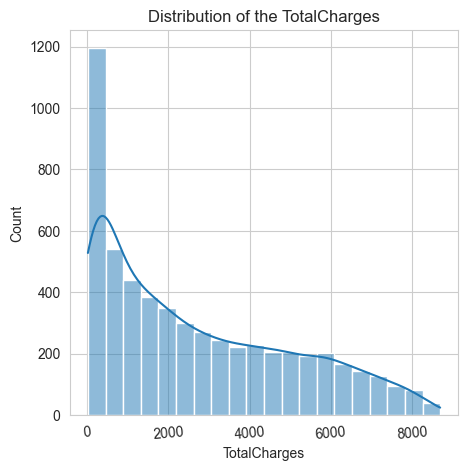

In [115]:
#plot the histogram
plt_hist(data_df['TotalCharges'])


We see a spike around 0 <TotalCharges <= 400, this spike may affect the model during training hence it will be removed.

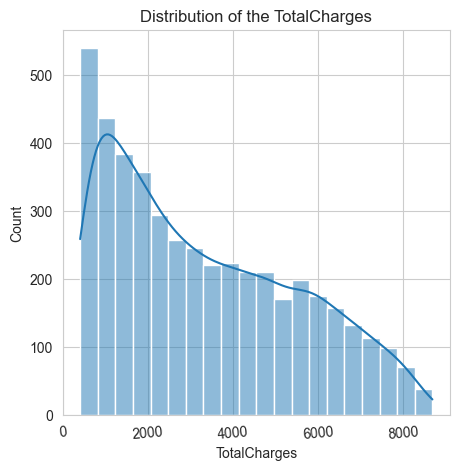

count    4534.000000
mean     3322.558678
std      2196.752374
min       401.100000
25%      1390.662500
50%      2881.075000
75%      5000.162500
max      8684.800000
Name: TotalCharges, dtype: float64


In [116]:
data_df = data_df[data_df['TotalCharges'] > 400]
plt_hist(data_df['TotalCharges'])
print(data_df['TotalCharges'].describe())

The data is right skewed (mean > median), thus there are more higher total chargers than there aare lower.

#### Total Charges and Churn

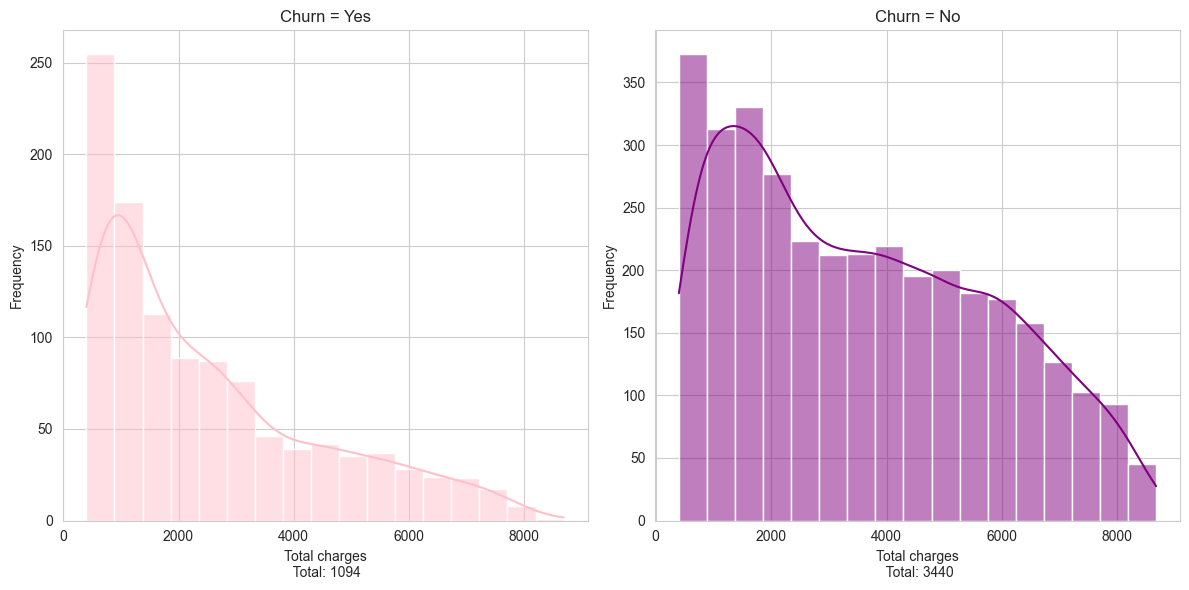

Percentage of customers who leave: 24.13%


In [117]:
yes = data_df[data_df['Churn'] == 'Yes']
no = data_df[data_df['Churn'] == 'No']

sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Churn = Yes
sns.histplot(data=data_df[data_df['Churn'] == 'Yes'], x='TotalCharges', ax=axes[0], kde=True, color='pink')
axes[0].set_title('Churn = Yes')
axes[0].set_xlabel(f'Total charges\n Total: {len(yes)}')
axes[0].set_ylabel('Frequency')


# Plot for MonthlyCharges Vs. Churn = no
sns.histplot(data=data_df[data_df['Churn'] == 'No'], x='TotalCharges', ax=axes[1], kde=True, color='purple')
axes[1].set_title('Churn = No')
axes[1].set_xlabel(f'Total charges\n Total: {len(no)}')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()
print(f"Percentage of customers who leave: {(len(yes)*100/ len(data_df)).__round__(2)}%")


Customers with total chargers > 4000, have a lower churn rate that customers with total charges between [400, 800], there are more customers staying in the region total costs > 4000 than leaving. The highest number of customers who are staying have total chargers between 400 and 2000.

#### Tenure

In [118]:
#Check the datatype we expect int. if object there are problems
print(f"Data type: {data_df['tenure'].dtype}")
#missing values
print(f"Missing values: {data_df['tenure'].isnull().sum()}")
#min and max values
print(f"Min: {data_df['tenure'].min()} \t Max: {data_df['tenure'].max()}")

Data type: int64
Missing values: 0
Min: 0 	 Max: 72


In [119]:
#Outliers
#find the quartile ranges to identify outliers
Q1= data_df['tenure'].quantile(0.25) 
Q3= data_df['tenure'].quantile(0.75)

inter_quartile_range = Q3-Q1

#find the inter quartile ranges
lower_bound = Q1 - (1.5*inter_quartile_range)
upper_bound = Q3 + (1.5*inter_quartile_range)

#isolate outliers
outliers_indexes = []
counter = 0
for index, row in enumerate(data_df['tenure']):
    if row < lower_bound:
        outliers_indexes.append(index)
    else:
        if row > upper_bound:
            outliers_indexes.append(index)
print(f"Total Number of Outliers: {len(outliers_indexes)}") 

Total Number of Outliers: 0


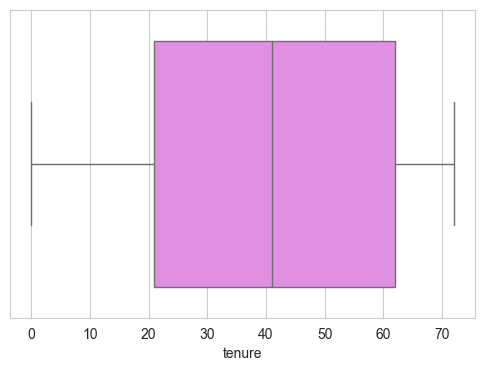

Number of outliers: 0
count    4534.000000
mean       40.828628
std        21.695158
min         0.000000
25%        21.000000
50%        41.000000
75%        62.000000
max        72.000000
Name: tenure, dtype: float64


In [120]:
#Plot the box plot of the Monthly charges column
plt.figure(figsize=(6,4))
sns.boxplot(x=data_df['tenure'], color='violet')
sns.swarmplot(x=Outliers_df, color='red', label='Outliers')
plt.show() 
print(f"Number of outliers: {len(Outliers_df)}")
print(data_df['tenure'].describe())

There is relatively more customers with a higher tenure than there are with a lower tenure. the data is positively skewed.

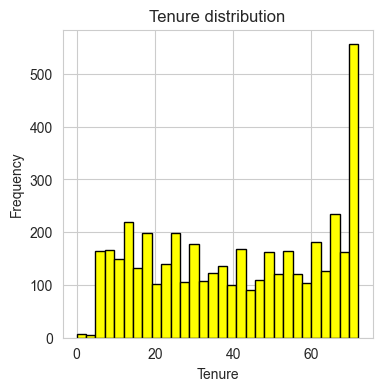

In [123]:
#histogram plot for tenure
plt.figure(figsize=(4,4))
plt.hist(data_df['tenure'], bins=30,color='yellow',edgecolor='black')
plt.title('Tenure distribution')
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [122]:
data_df = data_df[(data_df['tenure']) > 4 & (data_df['tenure']) < 68]
#histogram plot for tenure
plt.figure(figsize=(4,4))
plt.hist(data_df['tenure'], bins=30,color='yellow',edgecolor='black')
plt.title('Tenure distribution')
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<a id  = "3"></a>
## Data Transformation


This section will be dedicated to encoding the data before using it to train the ml models. This is done to imporve the performance of the ml model, to numereically represent the features and to avoid bais by the model (nlp).

- **Label encoding**: sutable for data with an intrinsic order in the categories (low medium high).
  - SeniorCitizen
  - Churn
- **One hot encoding**: Suitable for when the order is not important (this will be the rest of the columns).


In [ ]:
def ohe_columns(data):
    columns_to_ohe = ['gender', 'Partner','Dependents','PhoneService',
                      'MultipleLines', 'InternetService', 'OnlineSecurity',
                      'OnlineBackup', 'DeviceProtection', 'TechSupport',
                      'StreamingTV', 'StreamingMovies', 'Contract',
                      'PaperlessBilling', 'PaymentMethod']
    ohe = OneHotEncoder(
       use_cat_names = True,
       cols = columns_to_ohe 
    )
    ohe_df = ohe.fit_transform(data)
    return ohe_df

In [ ]:
def label_encoding(data):
    label_encoding = LabelEncoder()
    columns_to_LE = ['Churn', 'SeniorCitizen']
    
    for col in columns_to_LE:
        data[col] = label_encoding.fit_transform(data[col]).astype(int)
    return data

In [ ]:
#Encode columns
data_df = data_df.pipe(label_encoding).pipe(ohe_columns)


#### DELETE!!

In [ ]:
data_df = pd.read_csv("src/data/delete.csv")
#print(data_df.head())

<a id  = "4"></a>
## Models
- Logistic regression
- Random Forest

In [ ]:
#split data
X = data_df.drop(columns=['Churn'])
Y = data_df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Length of training data: {len(X_train)}\nLength of testing data {len(X_test)}")

Length of training data: 5625
Length of testing data 1407


In [ ]:
#Get baseline accuracy
acc_baseline = y_train.value_counts(normalize=True).max()*100
print(f"The accuracy baseline is: {round(acc_baseline,2)}%")

The accuracy baseline is: 73.42%


### Logistic Regression

hyper-parameters to tune:
- C : Regularization is used to prevent overfitting, this parameter controls the strength of regularization.
-  ...come back...

#### Grid Search
Grid search will be used to find the best combination of hyperparameters values for the model.

In [ ]:
#Get the optimal hyper parameter configurations
param_grid = {
    'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [2500, 5000, 7000]
}

#grid search object
grid_sobj = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')

#fit the grid search object to the data
grid_sobj.fit(X_train, y_train)
best_params = grid_sobj.best_params_
print(f"Best hyperparams: {best_params}")

KeyboardInterrupt: 

In [ ]:
#Build model
model_lr = make_pipeline(
    LogisticRegression(max_iter=best_params['max_iter'],
                       solver='liblinear',
                       C=best_params['C'])
)

#fit model
model_lr.fit(X_train,y_train)


Pipeline(steps=[('logisticregression',
                 LogisticRegression(C=6, max_iter=2500, solver='liblinear'))])

Training and validation accuracy score for the regression model:

In [ ]:
reg_train_acc = model_lr.score(X_train, y_train)
reg_test_acc = model_lr.score(X_test, y_test)

print(f"The training accuracy score is: {round(reg_train_acc*100,2)}%")
print(f"The testing accuracy score is: {round(reg_test_acc*100,2)}%")

The training accuracy score is: 80.69%
The testing accuracy score is: 78.75%


In [ ]:
#Extract and view important features
def ft_importance(model_nr, model):
    if(model_nr == 1):
        # Extract features and their coefficients
        coef = model.named_steps["logisticregression"].coef_[0]
        ft = X_train.columns
    
    else:
        coef = model.named_steps["randomforestclassifier"].feature_importances_
        ft = model.named_steps['randomforestclassifier'].feature_names_in_
    
    # Convert to Pandas Series
    ft_importance = pd.Series(
        np.exp(coef), index=ft
        ).sort_values(ascending=True)
    
    #Plot ft importance
    # Create horizontal bar chart of feature importances
    fig = px.bar(
        data_frame=ft_importance, 
        x=ft_importance[:16].values, 
        y=ft_importance[:16].index, 
        title="Feature Importance"
    )

    fig.update_layout(xaxis_title='Gini Importance', yaxis_title='')
    fig.show()
    return

In [ ]:
ft_importance(1, model_lr)

Having a partner that also uses the telecom streaming serivices, highly impacts the churn rate of the customer and having multiple affects if the customer will churn or not. customers with multiple lines are likely not to churn.

save model:

In [ ]:
joblib.dump(model_lr, 'artifacts/model_lr.pk1') 

['artifacts/model_lr.pk1']

The regression model predicted with an accuracy of 78.75%, adusting the solver type only improved the accuracy score by 1% fro 77%. The regression model is incredibly resource intensive and not suitable for this large dataset. Random forest model will be investigated.

### Random Forest
parameters:
- n-estimators (number of estimators):...
- max_depths:..... 

#### Feature Engineering

In [ ]:
def plt_acc(training_acc, validation_acc, esitmator, max_depths):
    train_acc_df = pd.DataFrame(training_acc, columns=['accuracy'])
    val_acc_df = pd.DataFrame(validation_acc, columns=['accuracy']) 
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=train_acc_df, x=max_depths, y='accuracy', palette=['blue'], marker='o', linestyle='-', ci=None)
    sns.lineplot(data=val_acc_df, x=max_depths, y='accuracy', palette=['red'], marker='o', linestyle='-', ci=None)
    plt.title(f'Training and Validation accuracy scores for Random Forest (n_estimators={esitmator})')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.legend(labels=['Training', 'Validation'])
    plt.show()
    return

In [ ]:
def train_rf(estimator):
    training_acc = []
    validation_acc= []
    max_depths_range = range(1,20)
    for max_depth in max_depths_range:
            # Initialize Random Forest model with current hyperparameters
            rf_model = RandomForestClassifier(
                n_estimators=estimator, 
                max_depth=max_depth, random_state=42)
            
            rf_model.fit(X_train, y_train)
            
            training_acc.append(rf_model.score(X_train,y_train))
            validation_acc.append(rf_model.score(X_test,y_test))
    plt_acc(training_acc, validation_acc, estimator, list(max_depths_range))
    return 

The following section of code was ran with a higher number of estimators. This took alot of time. hence the estimators will be reduced to the relevent numbers, because after a while it started repeating.

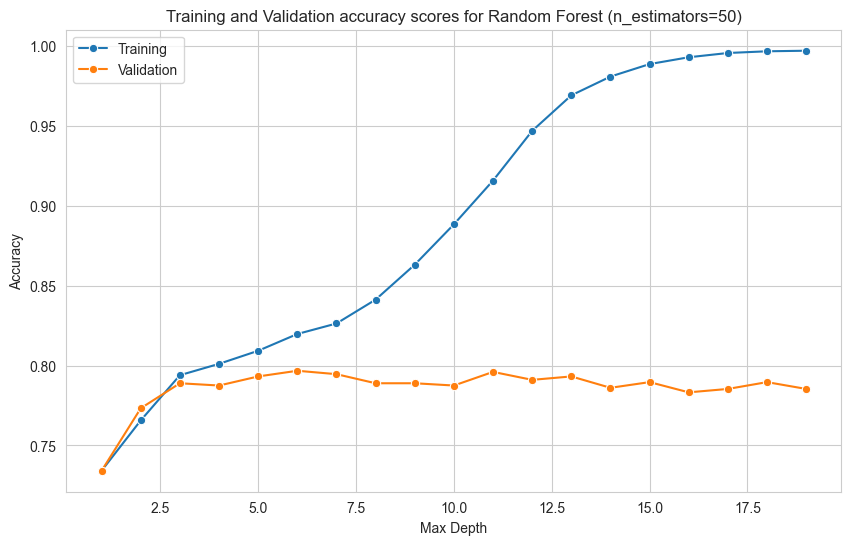

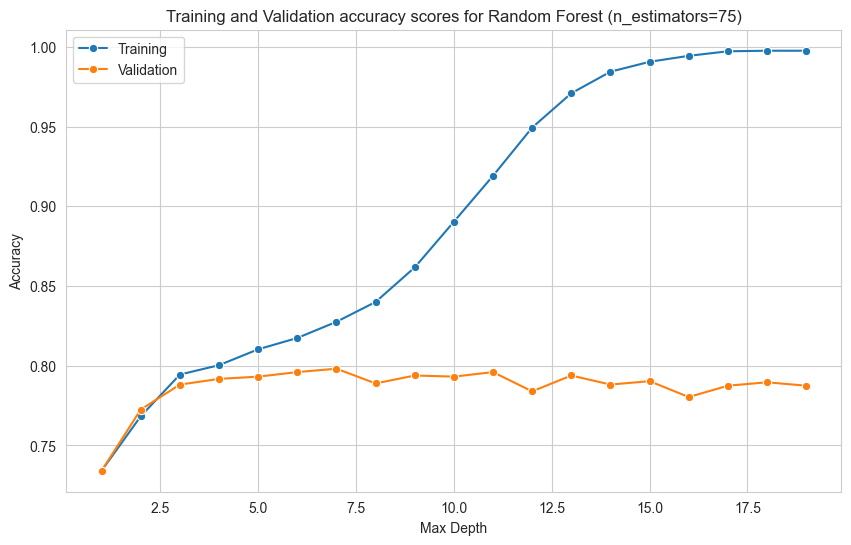

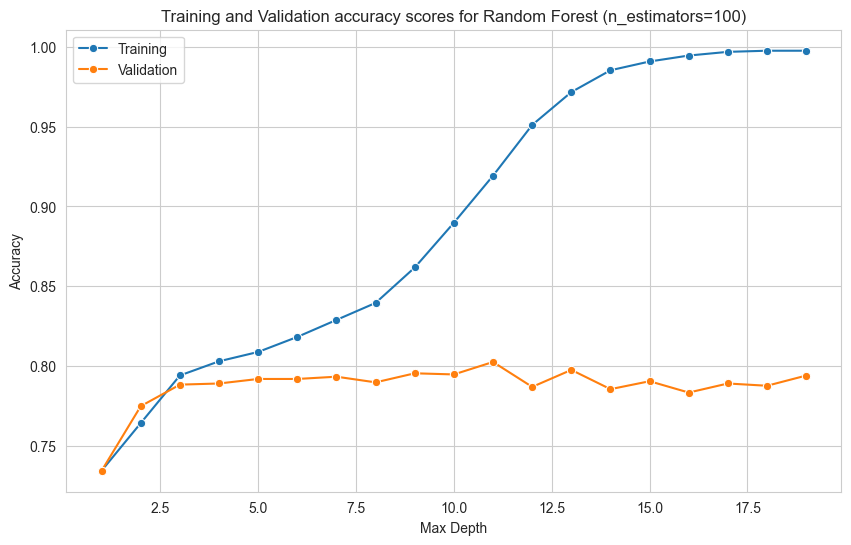

In [ ]:
n_estimators_range = [50, 75, 100]

for n in n_estimators_range:
    train_rf(n)

We see that at n_estimators = 100, and max depth = 11, we get the highest accuracy score.